In [2]:
import mne
import numpy as np
from pathlib import Path
import time

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from ica_benchmark.scoring import SCORING_FN_DICT, apply_pairwise_parallel
from ica_benchmark.processing.ica import get_all_methods, get_ica_instance
from ica_benchmark.processing.orica_code import ORICA

from ica_benchmark.io.load import BCI_IV_Comp_Dataset
from sklearn.cross_decomposition import PLSCanonical

from sacred.observers import MongoObserver, FileStorageObserver
from sacred import Experiment

import json

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV

from mne.decoding import CSP
from mne.time_frequency import psd_multitaper, psd_welch, psd_array_welch
from numpy.linalg import eig, pinv

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SequentialFeatureSelector
from itertools import product
import random


def cue_name(cue):
    return {
        0: "Left hand",
        1: "Right hand",
        2: "Foot",
        3: "Tongue",
    }[cue]

class ConcatenateChannelsPSD(BaseEstimator):
    def __init__(self):
        super(ConcatenateChannelsPSD).__init__()

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        n = len(x)
        return x.reshape(n, -1)


class PSD(BaseEstimator):
    BANDS_DICT = {
#         "delta": (1, 4),
#         "theta": (4, 8),
#         "mu": (8, 13),
        "mu": (8, 13),
#         "beta": (13, 25),
        "beta": (13, 25),
#         "gamma": (25, 40)
    }
    def __init__(self, **kwargs):
        super(PSD).__init__()
        self.kwargs = kwargs
        
    def set_params(**params):
        for param in params:
            assert params in ["picks", "n_fft", "n_overlap", "n_per_seg"]
        self.kwargs.update(params)
    
    def get_params(self, *args, **kwargs):
        return self.kwargs
        
    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        if isinstance(x, list):
            x = mne.concatenate_epochs(x)
            psds, freqs = psd_welch(x, ** self.kwargs)
        if isinstance(x, mne.Epochs):
            psds, freqs = psd_welch(x, ** self.kwargs)
        if isinstance(x, np.ndarray):
            psds, freqs = psd_array_welch(x, ** self.kwargs)
        if ("average" in self.kwargs) and (self.kwargs["average"] is None):
            psds = psds.sum(axis=3)
        self.freqs = freqs

        band_spectras = list()
        for band, (lfreq, hfreq) in self.BANDS_DICT.items():
            band_spectra = psds[:, :, (freqs >= lfreq) & (freqs < hfreq)]
            band_spectras.append(
                band_spectra.sum(axis=2, keepdims=True)
            )
        
        band_spectras = np.concatenate(band_spectras, axis=2)
            
        return band_spectras

def whitening(x, mean=None, std=None):
    is_epochs = isinstance(x, mne.Epochs)
    if is_epochs:
        epochs = x.copy()
        x = x._data
        is_epochs = True
        
    n_epochs, n_channels, n_times = x.shape
    
    x = x.transpose(1, 0, 2).reshape(n_channels, -1)
    if mean is None:
        mean = x.mean(axis=1, keepdims=True)
    
    if std is None:
        std = x.std(axis=1, keepdims=True)
        
    x -= mean
    x /= std
    
    x = x.reshape(n_channels, n_epochs, n_times).transpose(1, 0, 2)
    
    if is_epochs:
        epochs._data = x
        return epochs, mean, std
    
    return x, mean, std


def whitening(X, B=None):
    is_epochs = isinstance(X, mne.Epochs)
    if is_epochs:
        epochs = X.copy()
        X = X._data
        n_epochs, n_channels, n_times = X.shape
        X = X.transpose(1, 0, 2).reshape(n_channels, -1)
        
    if B is None:
    
        n, T = X.shape

        X -= X.mean(axis=1, keepdims=1)

        [D, U] = eig((X @ X.T) / float(T))
        # Sort by increasing variances
        k = D.argsort()
        Ds = D[k]

        # The m most significant princip. comp. by decreasing variance
        PCs = np.arange(n - 1, - 1, -1)

        # PCA
        # At this stage, B does the PCA on m components
        B = U[:, k[PCs]].T

        # --- Scaling ---------------------------------
        # The scales of the principal components
        scales = np.sqrt(Ds[PCs])
        B = np.diag(1.0 / scales) * B
        # Sphering
    
    X = B @ X
    
    
    if is_epochs:
#         X = B @ X
        X = X.reshape(n_channels, n_epochs, n_times).transpose(1, 0, 2)
        epochs._data = X
        X = epochs
    
    return X, B
    
root = Path("/home/paulo/Documents/datasets/BCI_Comp_IV_2a/gdf/")
selected_channels = ["EEG-Fz", "EEG-C3", "EEG-C4", "EEG-Cz"]
filepaths = sorted(root.glob("A*T.gdf"))

# clf.predict(full_epochs)

In [2]:
import functools

TEST_LABEL_FOLDER = Path("/home/paulo/Documents/datasets/BCI_Comp_IV_2a/true_labels/")
DEFAULT_TIME_BANDS = [(3, 6)]
def preprocess_epochs(epochs, timebands=None, car_filter=True):
    if timebands is None:
        timebands = DEFAULT_TIME_BANDS
    epochs = epochs.copy()
    
    epochs.load_data()
#     epochs.filter(5, 60)
    
    if car_filter:
        epochs.set_eeg_reference("average")
    events = epochs.events[:, 2]
#     epochs.drop(~((events == 0) | (events == 1)))

    partial_epochs = list()
#     for timeband in [(3, 5), (4, 6)]:
#     for timeband in [(0, 2), (1, 3), (3, 5), (4, 6)]:
#     for timeband in [(3, 4), (4, 5), (5, 6)]:
#     for timeband in [(3, 6)]:
#         partial_epochs.append(
#             epochs.copy().crop(*timeband).shift_time(-timeband[0])
#         )
#     epochs = mne.concatenate_epochs(partial_epochs).copy()
    return epochs

def load_subject_epochs(subject_number, test_label_folder=TEST_LABEL_FOLDER):
    train_file_path = root / "A{}T.gdf".format(str(subject_number).rjust(2, "0"))
    test_file_path = root / "A{}E.gdf".format(str(subject_number).rjust(2, "0"))
    test_label_file_path = test_label_folder / "A{}E.csv".format(str(subject_number).rjust(2, "0"))
    train_epochs = BCI_IV_Comp_Dataset.load_dataset(
        [train_file_path],
        reject=False,
        as_epochs=True,
        concatenate=False,
        drop_bad=False,
        return_metadata=False,
        tmin=0.,
        tmax=4.,
    )[0]
    test_epochs = BCI_IV_Comp_Dataset.load_dataset(
        [test_file_path],
        reject=False,
        as_epochs=True,
        concatenate=False,
        drop_bad=False,
        return_metadata=False,
        tmin=0.,
        # The last timestamp does not exist, so MNE will ignore the last epoch because it will not end in 6s
        # So here we use 5.5 seconds because there will always be 5.5 seconds after a event
        tmax=4.,
        has_labels=False
    )[0]

    train_epochs = preprocess_epochs(train_epochs, car_filter=False)
    test_epochs = preprocess_epochs(test_epochs, car_filter=False)
    
#     train_epochs.drop_bad(dict(eeg=1e-4))

    train_events = train_epochs.events[:, 2].flatten()
    train_epochs.drop(~((train_events == 0) | (train_events == 1)))
    train_labels = train_epochs.events[:, 2]
    
    test_labels = pd.read_csv(test_label_file_path, header=None).to_numpy().flatten() - 1
    assert len(test_labels) == len(test_epochs), "{} epochs | {} labels".format(len(test_epochs), len(test_labels))
    
    test_epochs.events[:, 2] = test_labels
    test_epochs.drop(~((test_labels == 0) | (test_labels == 1)))
    test_labels = test_epochs.events[:, 2]

    return (train_epochs, train_labels), (test_epochs, test_labels)



In [5]:

def get_corr_features(x):
    features = list()
    for i in range(len(x)):
        corr_matrix = np.corrcoef(x[i])
        idx1, idx2 = np.triu_indices(corr_matrix.shape[0], 1)
        features.append(
            corr_matrix[idx1, idx2].reshape(1, -1)
        )
    return np.vstack(features)


class CSPWrapper(BaseEstimator):
    def __init__(self, n_components=4):
        self.n_components = n_components
        self.csp = None

    def fit(self, x, y):
        self.csp = CSP(n_components=self.n_components)
        self.csp.fit(x, y)
        return self
    
    def transform(self, x):
        return self.csp.transform(x)
    
    def set_params(self, **params):
        self.n_components = params["n_components"]
        self.csp = CSP(n_components=self.n_components)
        return self
    
    def get_params(self, deep=True):
        return dict(n_components=self.n_components)
    
def run(filepath, ica_methods=None, channels=None, n_runs=10, random_state=1, lda_solver="svd"):
    np.random.seed(random_state)
    random.seed(random_state)
    
    ica_methods = [None] if ica_methods is None else ica_methods

    subject_number = int(filepath.name[1:3])
    (train_epochs, train_labels), (test_epochs, test_labels) = load_subject_epochs(subject_number)
        
    selected_channels = train_epochs.ch_names if channels is None else channels

    train_epochs.pick(selected_channels)
    test_epochs.pick(selected_channels)
    
    results = list()
    print("[{}]".format(filepath.name))
    for n_run, ica_method in product(range(n_runs), ica_methods):
        print("[{}/{}] Method: {}".format(n_run + 1, n_runs, ica_method))
        x_train, y_train = train_epochs.copy(), train_labels
        x_test, y_test = test_epochs.copy(), test_labels
        
        len_size = 250
        
#         if ica_method in ["sobi", "jade", "picard"]:
        # JADE and Picard needs whitening too, but
        # Used jade already whitens the signals
        # MNE whitens the signal when using PICARD
        if ica_method in ["sobi"]:
#             x_train, train_mean, train_std = whitening(x_train)
#             x_test, _, _ = whitening(x_test, mean=train_mean, std=train_std)
            x_train, B = whitening(x_train)
            x_test, _ = whitening(x_test, B)

        if ica_method == "none":
            x_train = x_train.get_data()
            x_test = x_test.get_data()
            psd = PSD(
                sfreq=train_epochs.info["sfreq"],
                n_fft=1 * len_size,
                n_overlap=len_size // 4,
                n_per_seg=1 * len_size,
                average="mean",
                window="hamming",
            )
        elif  "orica" in ica_method:
            x_train = x_train.get_data()
            x_test = x_test.get_data()
            n_sub = int(ica_method.split(" ")[-1])
            
            n_channels = len(selected_channels)
            ICA = ORICA(
                mode="decay",
                n_channels=n_channels,
                block_update=True,
                size_block=8,
                stride=8,
                lm_0=.995,
                lw_0=.995,
                gamma=.6,
                n_sub=n_sub,
            )
#             ICA.m_0 += np.random.rand(n_channels, n_channels) * .2
#             ICA.w_0 += np.random.rand(n_channels, n_channels) * .2
            ICA.fit(x_train)

            n_epochs, n_channels, n_times = x_train.shape
            x = x_train.transpose(1, 0, 2).reshape(n_channels, -1)
            x_train = (
                ICA
                .transform(
                    x,
                    scaling=1e6,
                    save=False,
                )
                .reshape(n_channels, n_epochs, n_times)
                .transpose(1, 0, 2)
            )

            #################################################################################
            ICA.mode = "constant"
            last_iter = ICA.iteration[-1]
            div = last_iter ** ICA.gamma            
            ICA.lm_0, ICA.lw_0 = 0.001, 0.001
            #################################################################################
            
            n_epochs, n_channels, n_times = x_test.shape
            x = x_test.transpose(1, 0, 2).reshape(n_channels, -1)
            x_test = (
                ICA
                .transform(
                    x,
                    scaling=1e6,
                    save=False,
                    warm_start=True
                )
                .reshape(n_channels, n_epochs, n_times)
                .transpose(1, 0, 2)
            )
            psd = PSD(
                sfreq=train_epochs.info["sfreq"],
                n_fft=1 * len_size,
                n_overlap=len_size // 4,
                n_per_seg=1 * len_size,
                average="mean",
                window="hamming",
            )
        else:
            ICA = get_ica_instance(ica_method, random_state=random_state + n_run)
            ica_channels = ["ICA{}".format(str(i).rjust(3, "0")) for i in range(len(selected_channels))]    

            ICA.fit(x_train)
            x_train = ICA.transform(x_train)
            x_test = ICA.transform(x_test)
            psd = PSD(
                picks=x_train.ch_names,
                n_fft=1 * len_size,
                n_overlap=len_size // 4,
                n_per_seg=1 * len_size,
                average="mean",
                window="hamming",
                proj=False
            )

            
        classifier = LDA(n_components=1, solver=lda_solver)
        SFS = SequentialFeatureSelector(
            LDA(n_components=1, solver=lda_solver),
            direction='forward',
            cv=4,
            scoring=make_scorer(cohen_kappa_score, greater_is_better=True)
        )
        param_grid = dict(
#             svc__C=np.logspace(-2, 2, 10),
#             svc__C=[.01, .1, 1, 10],
#             selectkbest__k=[10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, ]
#             lineardiscriminantanalysis__n_components=[1, 2, 4],
#             csp__n_components=[1, 2, 3, 4, 5]
            sequentialfeatureselector__n_features_to_select=[1, 2, 3, 5, 10, 15, 20, 30],
#             plscanonical__n_components=[1, 2, 3, 4, 5]
        )

        psd.fit(x_train)
        x_train = psd.transform(x_train)
        x_test = psd.transform(x_test)

        # 2 classes
        clf = make_pipeline(
            ConcatenateChannelsPSD(),
            StandardScaler(),
            SFS,
            classifier
        )

        gs_cv = GridSearchCV(
            clf,
            param_grid=param_grid,
            cv=4,
            scoring=make_scorer(cohen_kappa_score, greater_is_better=True),
            error_score=-1,
            refit=True,
            n_jobs=3,
            verbose=0
        )
#         print("Fitting... ", end="")
        start = time.time()
        gs_cv.fit(x_train, y_train)
        end = time.time()
#         print("Done (took {:.2f}s)".format(end - start))

        pred  = gs_cv.predict(x_test)
        bas = balanced_accuracy_score(y_test, pred)
        acc = accuracy_score(y_test, pred)
        kappa = cohen_kappa_score(y_test, pred)


        results.append(
            [
                n_run,
                ica_method,
                filepath.name.split(".")[0],
                acc,
                bas,
                kappa,
                end - start,
                gs_cv.best_params_
            ]
        )
        
        print("Kappa", kappa)
        print("Accuracy", acc)
#         print("BAS", bas)
    
    columns = ["run", "algorithm", "uid", "acc", "bas", "kappa", "ica_fit_time", "best_params"]
    results = pd.DataFrame(results, columns=columns)
    return results
        


In [4]:
# ica_methods = set(list(get_all_methods()) + ["orica"])

# For some reason ext_picard is giving the same results as picard
stochastic_methods = ["picard", "fastica", "infomax", "ext_infomax"]
# deterministic_methods = ["none", "sobi", "jade", "orica 0", "orica 1"]

lda_solver = "svd"
# ica_methods = set(list(get_all_methods()))
# exclude_methods = [
#     "choi_var",
#     "choi_vartd",
#     "choi_td",
#     "coro",
#     "ext_picard"
# ]
# ica_methods.difference_update(exclude_methods)

stochastic_results = dict()
deterministic_results = dict()



A01T.gdf
[A01T.gdf]
[1/1] Method: none
Kappa 0.3194444444444444
Accuracy 0.6597222222222222
[1/1] Method: sobi
Kappa 0.5
Accuracy 0.75
[1/1] Method: jade
Kappa 0.5
Accuracy 0.75
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.5277777777777778
Accuracy 0.7638888888888888
A02T.gdf
[A02T.gdf]
[1/1] Method: none
Kappa -0.125
Accuracy 0.4375
[1/1] Method: sobi
Kappa 0.01388888888888884
Accuracy 0.5069444444444444
[1/1] Method: jade
Kappa 0.02777777777777779
Accuracy 0.5138888888888888
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.11111111111111116
Accuracy 0.5555555555555556
A03T.gdf
[A03T.gdf]
[1/1] Method: none
Kappa 0.6527777777777778
Accuracy 0.8263888888888888
[1/1] Method: sobi
Kappa 0.8194444444444444
Accuracy 0.9097222222222222
[1/1] Method: jade
Kappa 0.5694444444444444
Accuracy 0.7847222222222222
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.6111111111111112
Accuracy 0.8055555555555556
A04T.gdf
[A04T.gdf]
[1/1] Method: none
Kappa 0.3055555555555556
Accuracy 0.6527777777777778
[1/1] Method: sobi
Kappa 0.23611111111111116
Accuracy 0.6180555555555556
[1/1] Method: jade
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.2777777777777778
Accuracy 0.6388888888888888
A05T.gdf
[A05T.gdf]
[1/1] Method: none
Kappa -0.13888888888888884
Accuracy 0.4305555555555556
[1/1] Method: sobi


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 590, in fit
    self._solve_svd(X, y)
  File "/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 4

Kappa -0.01388888888888884
Accuracy 0.4930555555555556
[1/1] Method: jade
Kappa 0.02777777777777779
Accuracy 0.5138888888888888
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.23611111111111116
Accuracy 0.6180555555555556
A06T.gdf
[A06T.gdf]
[1/1] Method: none
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
[1/1] Method: sobi
Kappa 0.11111111111111116
Accuracy 0.5555555555555556
[1/1] Method: jade
Kappa 0.25
Accuracy 0.625
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.19444444444444442
Accuracy 0.5972222222222222
A07T.gdf
[A07T.gdf]
[1/1] Method: none
Kappa 0.1527777777777778
Accuracy 0.5763888888888888
[1/1] Method: sobi
Kappa 0.01388888888888884
Accuracy 0.5069444444444444
[1/1] Method: jade
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.6388888888888888
Accuracy 0.8194444444444444
A08T.gdf
[A08T.gdf]
[1/1] Method: none
Kappa 0.6527777777777778
Accuracy 0.8263888888888888
[1/1] Method: sobi
Kappa 0.4027777777777778
Accuracy 0.7013888888888888
[1/1] Method: jade
Kappa 0.26388888888888884
Accuracy 0.6319444444444444
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.9027777777777778
Accuracy 0.9513888888888888
A09T.gdf
[A09T.gdf]
[1/1] Method: none
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
[1/1] Method: sobi
Kappa 0.5277777777777778
Accuracy 0.7638888888888888
[1/1] Method: jade
Kappa 0.6388888888888888
Accuracy 0.8194444444444444
[1/1] Method: orica


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.6527777777777778
Accuracy 0.8263888888888888
A01T.gdf
[A01T.gdf]
[1/10] Method: picard
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
[1/10] Method: fastica
Kappa 0.5555555555555556
Accuracy 0.7777777777777778
[1/10] Method: infomax
Kappa 0.4305555555555556
Accuracy 0.7152777777777778
[1/10] Method: ext_infomax
Kappa 0.5694444444444444
Accuracy 0.7847222222222222
[2/10] Method: picard
Kappa 0.5138888888888888
Accuracy 0.7569444444444444
[2/10] Method: fastica
Kappa 0.5833333333333333
Accuracy 0.7916666666666666
[2/10] Method: infomax
Kappa 0.48611111111111116
Accuracy 0.7430555555555556
[2/10] Method: ext_infomax
Kappa 0.7083333333333333
Accuracy 0.8541666666666666
[3/10] Method: picard
Kappa 0.6388888888888888
Accuracy 0.8194444444444444
[3/10] Method: fastica
Kappa 0.625
Accuracy 0.8125
[3/10] Method: infomax
Kappa 0.6388888888888888
Accuracy 0.8194444444444444
[3/10] Method: ext_infomax
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
[4/10] Method: picard
Kappa 0.

Kappa 0.8888888888888888
Accuracy 0.9444444444444444
[8/10] Method: picard
Kappa 0.7777777777777778
Accuracy 0.8888888888888888
[8/10] Method: fastica
Kappa 0.8888888888888888
Accuracy 0.9444444444444444
[8/10] Method: infomax
Kappa 0.6666666666666667
Accuracy 0.8333333333333334
[8/10] Method: ext_infomax
Kappa 0.875
Accuracy 0.9375
[9/10] Method: picard
Kappa 0.7777777777777778
Accuracy 0.8888888888888888
[9/10] Method: fastica
Kappa 0.8333333333333334
Accuracy 0.9166666666666666
[9/10] Method: infomax
Kappa 0.75
Accuracy 0.875
[9/10] Method: ext_infomax
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[10/10] Method: picard
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[10/10] Method: fastica
Kappa 0.875
Accuracy 0.9375
[10/10] Method: infomax
Kappa 0.8888888888888888
Accuracy 0.9444444444444444
[10/10] Method: ext_infomax
Kappa 0.7638888888888888
Accuracy 0.8819444444444444
A04T.gdf
[A04T.gdf]
[1/10] Method: picard
Kappa 0.36111111111111116
Accuracy 0.6805555555555556
[1/

Kappa 0.25
Accuracy 0.625
[5/10] Method: fastica
Kappa 0.16666666666666663
Accuracy 0.5833333333333334
[5/10] Method: infomax
Kappa 0.23611111111111116
Accuracy 0.6180555555555556
[5/10] Method: ext_infomax
Kappa 0.38888888888888884
Accuracy 0.6944444444444444
[6/10] Method: picard
Kappa 0.25
Accuracy 0.625
[6/10] Method: fastica
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
[6/10] Method: infomax
Kappa 0.25
Accuracy 0.625
[6/10] Method: ext_infomax
Kappa 0.3472222222222222
Accuracy 0.6736111111111112
[7/10] Method: picard
Kappa 0.25
Accuracy 0.625
[7/10] Method: fastica
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
[7/10] Method: infomax
Kappa 0.1527777777777778
Accuracy 0.5763888888888888
[7/10] Method: ext_infomax
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
[8/10] Method: picard
Kappa 0.25
Accuracy 0.625
[8/10] Method: fastica
Kappa 0.23611111111111116
Accuracy 0.6180555555555556
[8/10] Method: infomax
Kappa 0.23611111111111116
Accuracy 0.6180555555555556
[8/

Kappa 0.7222222222222222
Accuracy 0.8611111111111112
[4/10] Method: picard
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[4/10] Method: fastica
Kappa 0.7222222222222222
Accuracy 0.8611111111111112
[4/10] Method: infomax
Kappa 0.6944444444444444
Accuracy 0.8472222222222222
[4/10] Method: ext_infomax
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[5/10] Method: picard
Kappa 0.75
Accuracy 0.875
[5/10] Method: fastica
Kappa 0.75
Accuracy 0.875
[5/10] Method: infomax
Kappa 0.6527777777777778
Accuracy 0.8263888888888888
[5/10] Method: ext_infomax
Kappa 0.7222222222222222
Accuracy 0.8611111111111112
[6/10] Method: picard
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[6/10] Method: fastica
Kappa 0.75
Accuracy 0.875
[6/10] Method: infomax
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[6/10] Method: ext_infomax
Kappa 0.7361111111111112
Accuracy 0.8680555555555556
[7/10] Method: picard
Kappa 0.75
Accuracy 0.875
[7/10] Method: fastica
Kappa 0.7361111111111112
Accuracy 0.

In [ ]:
for filepath in filepaths:
    print(filepath.name)
    subject_results_dict = run(filepath, ica_methods=stochastic_methods, n_runs=10, lda_solver=lda_solver)
    stochastic_results[filepath.name] = subject_results_dict


In [16]:
deterministic_methods = ["none", "sobi", "jade", "orica 0", "orica 1"]

for filepath in filepaths:
    print(filepath.name)
    subject_results_dict = run(filepath, ica_methods=deterministic_methods, n_runs=1, lda_solver=lda_solver)
    deterministic_results[filepath.name] = subject_results_dict

A01T.gdf
[A01T.gdf]
[1/1] Method: none
Kappa 0.3194444444444444
Accuracy 0.6597222222222222
[1/1] Method: sobi
Kappa 0.5
Accuracy 0.75
[1/1] Method: jade
Kappa 0.5
Accuracy 0.75
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.5277777777777778
Accuracy 0.7638888888888888
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.36111111111111116
Accuracy 0.6805555555555556
A02T.gdf
[A02T.gdf]
[1/1] Method: none
Kappa -0.125
Accuracy 0.4375
[1/1] Method: sobi
Kappa 0.01388888888888884
Accuracy 0.5069444444444444
[1/1] Method: jade
Kappa 0.02777777777777779
Accuracy 0.5138888888888888
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.11111111111111116
Accuracy 0.5555555555555556
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa -0.01388888888888884
Accuracy 0.4930555555555556
A03T.gdf
[A03T.gdf]
[1/1] Method: none
Kappa 0.6527777777777778
Accuracy 0.8263888888888888
[1/1] Method: sobi
Kappa 0.8194444444444444
Accuracy 0.9097222222222222
[1/1] Method: jade
Kappa 0.5694444444444444
Accuracy 0.7847222222222222
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.6111111111111112
Accuracy 0.8055555555555556
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.75
Accuracy 0.875
A04T.gdf
[A04T.gdf]
[1/1] Method: none
Kappa 0.3055555555555556
Accuracy 0.6527777777777778
[1/1] Method: sobi
Kappa 0.23611111111111116
Accuracy 0.6180555555555556
[1/1] Method: jade
Kappa 0.2777777777777778
Accuracy 0.6388888888888888
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.2777777777777778
Accuracy 0.6388888888888888
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.26388888888888884
Accuracy 0.6319444444444444
A05T.gdf
[A05T.gdf]
[1/1] Method: none
Kappa -0.13888888888888884
Accuracy 0.4305555555555556
[1/1] Method: sobi


/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1 fits failed out of a total of 4.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 590, in fit
    self._solve_svd(X, y)
  File "/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/sklearn/discriminant_analysis.py", line 4

Kappa -0.01388888888888884
Accuracy 0.4930555555555556
[1/1] Method: jade
Kappa 0.02777777777777779
Accuracy 0.5138888888888888
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.23611111111111116
Accuracy 0.6180555555555556
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa -0.04166666666666674
Accuracy 0.4791666666666667
A06T.gdf
[A06T.gdf]
[1/1] Method: none
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
[1/1] Method: sobi
Kappa 0.11111111111111116
Accuracy 0.5555555555555556
[1/1] Method: jade
Kappa 0.25
Accuracy 0.625
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.19444444444444442
Accuracy 0.5972222222222222
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.08333333333333337
Accuracy 0.5416666666666666
A07T.gdf
[A07T.gdf]
[1/1] Method: none
Kappa 0.1527777777777778
Accuracy 0.5763888888888888
[1/1] Method: sobi
Kappa 0.01388888888888884
Accuracy 0.5069444444444444
[1/1] Method: jade
Kappa 0.18055555555555558
Accuracy 0.5902777777777778
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.6388888888888888
Accuracy 0.8194444444444444
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.38888888888888884
Accuracy 0.6944444444444444
A08T.gdf
[A08T.gdf]
[1/1] Method: none
Kappa 0.6527777777777778
Accuracy 0.8263888888888888
[1/1] Method: sobi
Kappa 0.4027777777777778
Accuracy 0.7013888888888888
[1/1] Method: jade
Kappa 0.26388888888888884
Accuracy 0.6319444444444444
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.9027777777777778
Accuracy 0.9513888888888888
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.8194444444444444
Accuracy 0.9097222222222222
A09T.gdf
[A09T.gdf]
[1/1] Method: none
Kappa 0.6111111111111112
Accuracy 0.8055555555555556
[1/1] Method: sobi
Kappa 0.5277777777777778
Accuracy 0.7638888888888888
[1/1] Method: jade
Kappa 0.6388888888888888
Accuracy 0.8194444444444444
[1/1] Method: orica 0


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.6527777777777778
Accuracy 0.8263888888888888
[1/1] Method: orica 1


  0%|          | 0/18018 [00:00<?, ?it/s]

  0%|          | 0/18018 [00:00<?, ?it/s]

Kappa 0.7361111111111112
Accuracy 0.8680555555555556


In [60]:
deterministic_results_list = list()
for i in range(10):
    df = pd.concat(list(deterministic_results.values()))
    df.run = i
    deterministic_results_list.append(df)
    
deterministic_results_df = pd.concat(deterministic_results_list)
results_df = pd.concat(
    list(stochastic_results.values()) + [deterministic_results_df]
)


def alg_rename(alg_name):
    alg_rename_dict = {
        "ext_infomax": "Ext. Infomax",
        "infomax": "Infomax",
        "none": "None",
        "picard": "Picard",
        "orica 0": "Orica (0 SGS)",
        "orica 1": "Orica (1 SGS)",
        "jade": "JADE",
        "sobi": "SOBI",
        "fastica": "FastICA"
    }
    return alg_rename_dict.get(alg_name, alg_name)

results_df.algorithm = results_df.algorithm.apply(alg_rename)

results_df.to_csv("results.csv", index=False)

In [3]:
results_df = pd.read_csv("results.csv", index_col=None)

In [4]:
results_df.algorithm.unique()

array(['Picard', 'FastICA', 'Infomax', 'Ext. Infomax', 'None', 'SOBI',
       'JADE', 'Orica (0 SGS)', 'Orica (1 SGS)'], dtype=object)

In [62]:
pd.set_option('display.max_rows', None)

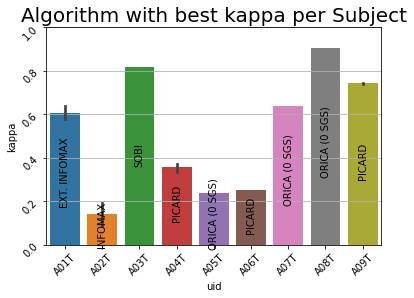

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties.

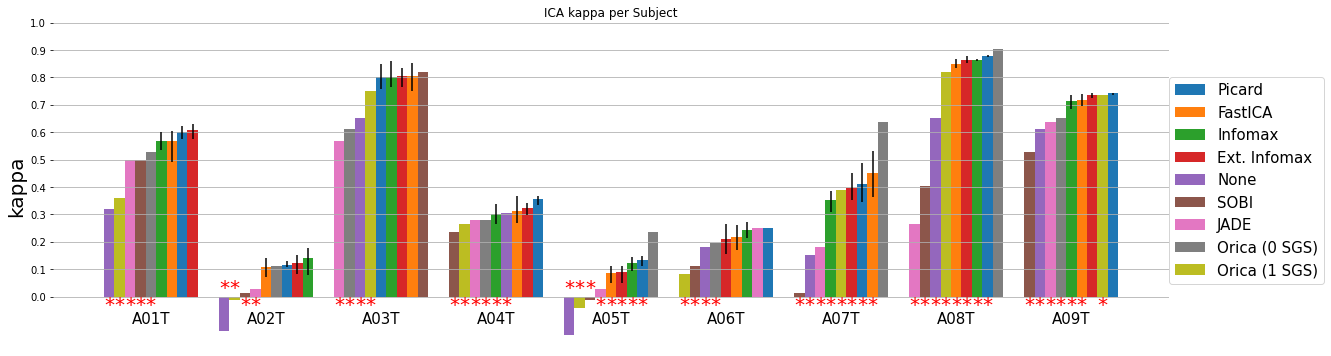

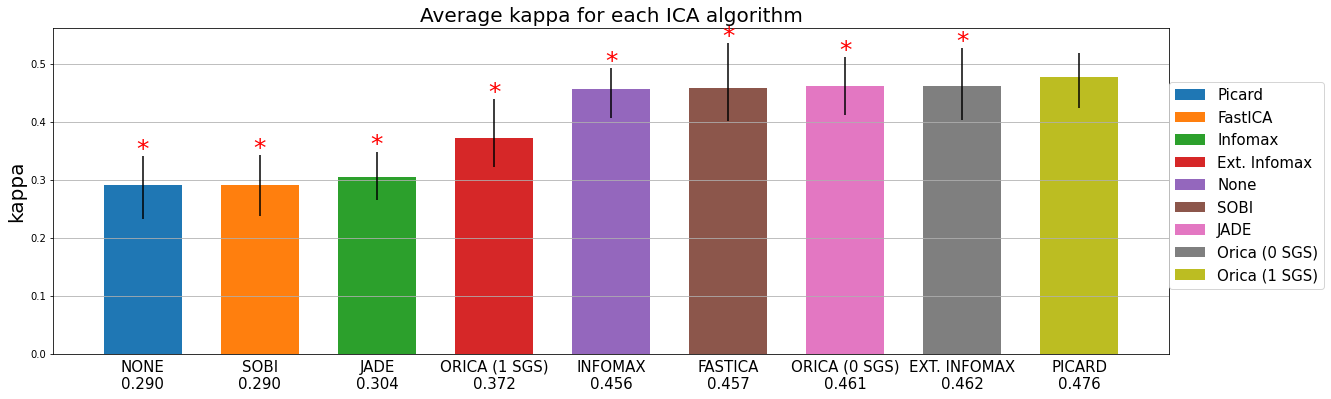

In [65]:
from matplotlib.colors import Colormap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import bootstrap, wilcoxon


metrics = ["bas", "kappa", "acc"]
def flatten_results(results_dict):
    lines = list()
    columns = ["uid", "algorithm", "metric", "value"]
    for uid, alg_metrics in results_dict.items():
        for alg_name, metrics in alg_metrics.items():
            for metric_name, value in metrics.items():
                lines.append(
                    [uid, alg_name, metric_name, value]
                )
    results_df = pd.DataFrame(lines, columns=columns)
    return  results_df


def plot_sub_barplot(results_df, metric="kappa", algorithms=None, figsize=None):
    
    if figsize is None:
        figsize = (12, 5)
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
    df = results_df.query("algorithm in @algorithms")
    
    
    plt.figure(figsize=figsize)
    plt.grid()
    sns.barplot(x="uid", y=metric, data=df, hue="algorithm", ax=plt.gca())
    plt.show()
    

def plot_best_algorithm(results_df, metric="kappa", algorithms=None, figsize=None):
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
    df = results_df.query("(metric == @metric) & (algorithm in @algorithms)")
    return df.groupby("uid").max()


def single(ax, labels):
    for p, label in zip(ax.patches, labels):
        _x = p.get_x() + p.get_width() / 2 
        _y = (p.get_y() + p.get_height() - len(label)/ 50) / 2
        ax.text(_x, _y, label.upper(), ha="center", rotation=90) 

def plot_best_algorithm(results_df, metric="kappa", algorithms=None, figsize=None):
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
    df = results_df.query("(algorithm in @algorithms)").groupby(["uid", "algorithm"], as_index=False).mean()
    df = df.sort_values(by=metric, ascending=False).drop_duplicates(subset="uid").sort_values(by="uid", ascending=True)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.grid()
    sns.barplot(x="uid", y=metric, data=df, label="algorithm", ax=ax)
    single(ax, df.algorithm.to_numpy())
    ax.tick_params(labelrotation=45)
    ax.set_ylim((0, 1))
    plt.show()

def plot_best_algorithm(results_df, metric="kappa", algorithms=None, figsize=None):
    if algorithms is None:
        algorithms = results_df.algorithm.unique()
    
#     df = results_df.query("(algorithm in @algorithms)").groupby(["uid", "algorithm"], as_index=False).agg(["mean", "min", "max"]).reset_index().drop_duplicates(subset=[("uid", "")])
#     df = df.sort_values(by=(metric, "mean"), ascending=False).sort_values(by=[("uid", "")])
    df = results_df.query("(algorithm in @algorithms)").groupby(["uid", "algorithm"], as_index=False).mean()
    df = df.sort_values(by=metric, ascending=False).drop_duplicates(subset="uid")
    df = results_df.query("(algorithm in @algorithms)").merge(df[["uid", "algorithm"]], on=["uid", "algorithm"], how="inner").sort_values(by="uid", ascending=True)
    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax.grid()
    sns.barplot(x="uid", y=metric, data=df, label="algorithm", ax=ax)
    single(ax, df.drop_duplicates(subset=["uid"]).algorithm.to_numpy())
    ax.tick_params(labelrotation=45)
    ax.set_ylim((0, 1))
    ax.set_title(f"Algorithm with best {metric} per Subject", fontsize=20)
    plt.show()

    
    
def get_pvalue(a, b, alternative="greater"):
    if len(a) == len(b):
        return wilcoxon(a, b, alternative=alternative, zero_method="zsplit")
    
    elif (len(a) != len(b)) and ((len(a) == 1) or (len(b) == 1)):
        len_1_var = a if len(a) == 1 else b
        len_n_var = b if len(a) == 1 else a
        return wilcoxon(len_n_var - len_1_var, alternative=alternative)
    
    else:
        return ranksums(a, b, alternative=alternative)
    
    
def get_wilcoxon_algorithms(results_df, uid, alg1, alg2, alternative="greater", metric="kappa"):
    a = results_df.query("(uid == @uid) and (algorithm == @alg1)").sort_values(by="run")[metric]
    b = results_df.query("(uid == @uid) and (algorithm == @alg2)").sort_values(by="run")[metric]
    try:
        wilcoxon(a, b, alternative=alternative, zero_method="zsplit")
    except:
        display(results_df.query("(uid == @uid) and (algorithm == @alg1)").sort_values(by="run"))
        display(results_df.query("(uid == @uid) and (algorithm == @alg2)").sort_values(by="run"))
        raise Exception
#     if len(a) == len(b):
#         return wilcoxon(a, b, alternative=alternative)
    
#     elif (len(a) != len(b)) and ((len(a) == 1) or (len(b) == 1)):
#         return wilcoxon(a - b, alternative=alternative)
    
    
    return wilcoxon(a, b, alternative=alternative, zero_method="zsplit")

def get_wilcoxon(results_df, alg1, alg2, alternative="greater", metric="kappa"):
    r1 = results_df.query("(algorithm == @alg1)").sort_values(by=["uid", "run"])[metric]
    r2 = results_df.query("(algorithm == @alg2)").sort_values(by=["uid", "run"])[metric]
    return wilcoxon(r1, r2, alternative=alternative, zero_method="zsplit")

def sortedgroupedbar(results_df, metric="kappa"):
    w = 5
    plt.figure(figsize=(20, 6))
    ax = plt.gca()
    cmap = plt.get_cmap("tab10")
    algs = results_df.algorithm.unique()
    n_algs = len(algs)
    algorithm_color_dict = {
        alg: cmap(i / n_algs)
        for i, alg
        in enumerate(algs)
    }
    
    x_c = w / 2
    legends = [
         Patch(
             facecolor=algorithm_color_dict[alg],
             edgecolor=None,
             label=alg
         )
        for alg in algs
    ]
    algorithms = results_df.algorithm.unique()
    uids = results_df.uid.unique()
    
#     for uid, algorithm in product(uids, algorithms):
    for uid in uids:
        x_list = list()
        algorithms = results_df.query("uid == @uid").groupby("algorithm", as_index=False).mean().sort_values(by=metric).algorithm.to_numpy()
        best_algorithm = algorithms[-1]
        for algorithm in algorithms:
            df = results_df.query("(uid == @uid) and (algorithm == @algorithm)")
#             display(df)
#             return
            if df[metric].nunique() > 1:
                res = bootstrap((df[metric], ), np.mean, n_resamples=100)
                low = res.confidence_interval.low
                high = res.confidence_interval.high
            else:
                low, high = 0, 0
            avg = df[metric].mean()
            low, high = avg - low, high - avg
#             low, high = avg - df[metric].min(), df[metric].max() - avg
            x_list.append(x_c)
            ax.bar(x_c, avg, width=w, color=algorithm_color_dict[algorithm], yerr=([low], [high]))
            if (algorithm != best_algorithm):
                pvalue = get_wilcoxon_algorithms(results_df, uid, best_algorithm, algorithm).pvalue
                if (pvalue < 0.05):
                    ax.text(x_c, -0.03 if avg > 0 else 0.03, "*", ha="center", va="center", fontsize=20, color="r")
            x_c += w
        x_c += w * 2

        mid = np.mean(x_list)
        ax.text(mid, -0.1, uid, horizontalalignment="center", fontsize=15)
        
#         ax.set_xticks()
        
    for loc in ["right", "left", "top", "bottom"]:
        ax.spines[loc].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks(np.arange(0, 1.01, 0.1))
    ax.grid()
    ax.legend(handles=legends, loc=(1, .2), fontsize=15)
    ax.set_ylabel(metric, fontsize=20)
    ax.set_title(f"ICA {metric} per Subject")
    plt.show()
    
def plot_average_algorithm_metric(results_df, metric="kappa"):
    w = 5
    plt.figure(figsize=(20, 6))
    ax = plt.gca()
    cmap = plt.get_cmap("tab10")
    algs = results_df.algorithm.unique()
    n_algs = len(algs)
    algorithm_color_dict = {
        alg: cmap(i / n_algs)
        for i, alg
        in enumerate(algs)
    }
    
    x_c = w / 2
    legends = [
         Patch(
             facecolor=algorithm_color_dict[alg],
             edgecolor=None,
             label=alg
         )
        for alg in algs
    ]
    sorted_df = results_df.groupby(["uid", "algorithm"]).mean().groupby("algorithm").mean().sort_values(by=metric).reset_index()
#     for algorithm in results_df.algorithm.unique():
#         df = results_df.groupby(["uid", "algorithm"]).mean().groupby("algorithm").mean()
#     display(results_df.algorithm)
#     sns.barplot(x="algorithm", y=metric, df=results_df)
    x_c = 0
    best_algorithm = sorted_df.algorithm.to_numpy()[-1]
    for algorithm in sorted_df.algorithm:
        df = results_df.query("algorithm == @algorithm")
        res = bootstrap((df[metric], ), np.mean, n_resamples=100)
        x_c += 1.5 * w
        avg = df[metric].mean()
        ax.bar(x_c, avg, w, yerr=([avg - res.confidence_interval.low], [res.confidence_interval.high - avg]))
        ax.set_xticks([])
        ax.text(x_c, -0.03, algorithm.upper(), horizontalalignment="center", fontsize=15)
        ax.text(x_c, -0.06, "{:.3f}".format(avg), horizontalalignment="center", fontsize=15)
        if (best_algorithm != algorithm):
            pvalue = get_wilcoxon(results_df, best_algorithm, algorithm).pvalue
            if (pvalue < 0.05):
                ax.text(x_c, res.confidence_interval.high, "*".format(pvalue), horizontalalignment="center", fontsize=25, color="r")
#                 ax.text(x_c, res.confidence_interval.low-.02, "p={:.3f}".format(pvalue), horizontalalignment="center", fontsize=15, color="r")
    ax.legend(handles=legends, loc=(1, .2), fontsize=15)
    ax.set_ylabel(metric, fontsize=20)
    ax.grid()
    ax.set_title(f"Average {metric} for each ICA algorithm", fontsize=20)
    plt.show()
# plot_sub_barplot(results_df, metric="kappa")
plot_best_algorithm(results_df.query("algorithm != 'ext_picard'"), "kappa")
sortedgroupedbar(results_df.query("algorithm != 'ext_picard'"), "kappa")
plot_average_algorithm_metric(results_df.query("algorithm != 'ext_picard'"))


In [92]:
results_df.groupby(["algorithm"]).agg([np.mean, np.std])["kappa"].sort_values(by="mean")

/tmp/ipykernel_588686/336311055.py:1: FutureWarning: ['uid', 'best_params'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df.groupby(["algorithm"]).agg([np.mean, np.std])["kappa"].sort_values(by="mean")


,mean,std
algorithm,,
None,0.290123,0.291146
SOBI,0.290123,0.275068
JADE,0.304012,0.210424
Orica (1 SGS),0.371914,0.316426
Infomax,0.456327,0.279082
FastICA,0.457253,0.292918
Orica (0 SGS),0.461420,0.252671
Ext. Infomax,0.461574,0.290494
Picard,0.476389,0.279190


In [85]:
df = results_df.groupby(["uid", "algorithm"], as_index=False).mean()
df = df.sort_values(by="kappa", ascending=False).drop_duplicates(subset="uid")
results_df \
    .merge(
        df[["uid", "algorithm"]],
        on=["uid", "algorithm"],
        how="inner"
    ) \
    .groupby(["uid"]) \
    .agg([np.mean, np.std]) \
    .merge(
        df[["uid", "algorithm"]].rename(columns=dict(algorithm=("algorithm", ""))),
        on="uid",
        how="inner"
    )[["uid", "algorithm", "kappa"]]

/tmp/ipykernel_588686/1479335649.py:3: FutureWarning: ['algorithm', 'best_params'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  results_df \
/tmp/ipykernel_588686/1479335649.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  results_df \


uid      algorithm     kappa          
                            mean       std
0  A01T   Ext. Infomax  0.606944  0.051574
1  A02T        Infomax  0.138889  0.096448
2  A03T           SOBI  0.819444  0.000000
3  A04T         Picard  0.355556  0.028689
4  A05T  Orica (0 SGS)  0.236111  0.000000
5  A06T         Picard  0.250000  0.000000
6  A07T  Orica (0 SGS)  0.638889  0.000000
7  A08T  Orica (0 SGS)  0.902778  0.000000
8  A09T         Picard  0.741667  0.007172

In [87]:
results_df.query("(algorithm == 'Picard') and (uid == 'A01T')")

,run,algorithm,uid,acc,bas,kappa,ica_fit_time,best_params
0,0,Picard,A01T,0.805556,0.805556,0.611111,54.673769,{'sequentialfeatureselector__n_features_to_sel...
4,1,Picard,A01T,0.756944,0.756944,0.513889,53.168618,{'sequentialfeatureselector__n_features_to_sel...
8,2,Picard,A01T,0.819444,0.819444,0.638889,54.598245,{'sequentialfeatureselector__n_features_to_sel...
12,3,Picard,A01T,0.805556,0.805556,0.611111,49.289410,{'sequentialfeatureselector__n_features_to_sel...
16,4,Picard,A01T,0.819444,0.819444,0.638889,60.765848,{'sequentialfeatureselector__n_features_to_sel...
20,5,Picard,A01T,0.805556,0.805556,0.611111,54.123300,{'sequentialfeatureselector__n_features_to_sel...
24,6,Picard,A01T,0.805556,0.805556,0.611111,53.720871,{'sequentialfeatureselector__n_features_to_sel...
28,7,Picard,A01T,0.756944,0.756944,0.513889,51.395566,{'sequentialfeatureselector__n_features_to_sel...
32,8,Picard,A01T,0.812500,0.812500,0.625000,53.006322,{'sequentialfeatureselector__n_features_to_sel...
36,9,Picard,A01T,0.819444,0.819444,0.638889,50.371351,{'sequentialfeatureselector__n_features_to_sel...


In [45]:
wilcoxon(
    results_df.query("algorithm == 'picard'")["kappa"],
    results_df.query("algorithm == 'ext_infomax'")["kappa"],
    alternative="greater"
)

WilcoxonResult(statistic=2107.0, pvalue=0.017690743007983435)

In [31]:
results_df.query("algorithm == 'ext_infomax'")["kappa"].mean()

0.461574074074074

In [32]:
results_df.query("algorithm == 'picard'")["kappa"].mean()

0.476388888888889

In [462]:
wilcoxon([3], alternative="greater")

WilcoxonResult(statistic=1.0, pvalue=0.5)

In [449]:
def get_pvalue(a, b, alternative="greater"):
    if len(a) == len(b):
        print("a")
        return wilcoxon(a, b, alternative=alternative)
    
    elif (len(a) != len(b)) and ((len(a) == 1) or (len(b) == 1)):
        return wilcoxon(a - b, alternative=alternative)
    
    else:
        return ranksums(a, b, alternative=alternative)

a1 = results_df.query("(algorithm == 'fastica') ").sort_values(by=["uid", "run"])["kappa"].values
a2 = results_df.query("(algorithm == 'orica')").sort_values(by=["uid", "run"])["kappa"].values
len(a1), len(a2), get_pvalue(a1, a2)


(90,
 9,
 RanksumsResult(statistic=0.6450954566171957, pvalue=0.2594326639846923))

In [477]:
pd.concat(results_orica.values()).

AttributeError: 'DataFrame' object has no attribute 'repeat'

<AxesSubplot:>

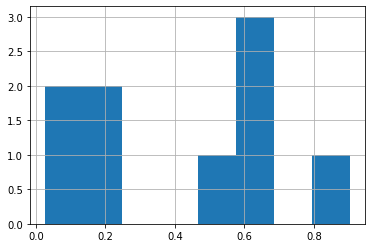

In [474]:
results_df.query("(algorithm == 'orica')").sort_values(by=["uid", "run"])["kappa"].hist(bins=8)

In [293]:
from scipy.stats import wilcoxon, ranksums

metric = "kappa"

for uid in results_df.uid.unique():
    sorted_results_df = (
        results_df
        .query("algorithm != 'ext_picard'")
        .query("uid == @uid")
        .groupby("algorithm", as_index=False)
        .mean()
        .sort_values(by=metric)
#         .drop_duplicates(subset="uid")
    )
    best_alg = (
        sorted_results_df
        .tail(1)
        .algorithm
        .item()
    )
    best_alg_results = results_df.query("(uid == @uid) and (algorithm == @best_alg)").sort_values(by="run")[metric]
    print(uid)
    for sec_alg in sorted_results_df.algorithm.to_numpy()[:-1]:
        
        sec_results = results_df.query("(uid == @uid) and (algorithm == @sec_alg)").sort_values(by="run")[metric]
        print("\t{} vs {}: {}".format(best_alg, sec_alg, wilcoxon(best_alg_results, sec_results, alternative="greater")))
        
#     wilcoxon(a1, a2, mode="exact")

A01T
	ext_infomax vs sobi: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	ext_infomax vs jade: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	ext_infomax vs orica: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	ext_infomax vs infomax: WilcoxonResult(statistic=27.0, pvalue=0.10351049860993056)
	ext_infomax vs fastica: WilcoxonResult(statistic=25.0, pvalue=0.16230305586309102)
	ext_infomax vs picard: WilcoxonResult(statistic=18.5, pvalue=0.6823553405823966)
A02T
	infomax vs sobi: WilcoxonResult(statistic=54.0, pvalue=0.001953125)
	infomax vs jade: WilcoxonResult(statistic=52.0, pvalue=0.0048828125)
	infomax vs fastica: WilcoxonResult(statistic=31.0, pvalue=0.1561170999698141)
	infomax vs picard: WilcoxonResult(statistic=32.0, pvalue=0.1291471555931335)
	infomax vs orica: WilcoxonResult(statistic=36.0, pvalue=0.2158203125)
	infomax vs ext_infomax: WilcoxonResult(statistic=33.0, pvalue=0.3125)
A03T
	fastica vs orica: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	fa

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximati


	orica vs sobi: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	orica vs infomax: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	orica vs ext_infomax: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	orica vs fastica: WilcoxonResult(statistic=36.0, pvalue=0.005808022449631236)
	orica vs picard: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
A08T
	orica vs jade: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	orica vs sobi: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	orica vs fastica: WilcoxonResult(statistic=45.0, pvalue=0.0037631575832289435)
	orica vs ext_infomax: WilcoxonResult(statistic=45.0, pvalue=0.0033030736763512156)
	orica vs infomax: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	orica vs picard: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
A09T
	ext_infomax vs jade: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	ext_infomax vs orica: WilcoxonResult(statistic=55.0, pvalue=0.0009765625)
	ext_infomax vs sobi: WilcoxonResult

/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/paulo/anaconda3/envs/bci_update/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximati

In [214]:
from scipy.stats import wilcoxon

metric = "kappa"
sorted_df = results_df.sort_values(by=["uid", "run", "algorithm"])
algorithms = list(results_df.algorithm.unique())

algorithms.remove('ext_picard')
algorithms.remove('orica')
algorithms = ["orica"] + algorithms

tested = list()
for alg1, alg2 in product(algorithms, algorithms):
    test_algs = set([alg1, alg2])
    if (alg1 == alg2) or (test_algs in tested):
        continue
    tested.append(test_algs)
    r1 = sorted_df.query("algorithm == @alg1")[metric]
    r2 = sorted_df.query("algorithm == @alg2")[metric]
    if r1.mean() > r2.mean():
        alternative = "greater"
    else:
        alternative = "less"
    test = wilcoxon(r1, r2, alternative=alternative)
    print("{} ({:.3f}) vs {} ({:.3f}): {} ({})".format(alg1, r1.mean(), alg2, r2.mean(), test, alternative))

orica (0.461) vs ext_infomax (0.462): WilcoxonResult(statistic=1755.0, pvalue=0.3093948383983808) (less)
orica (0.461) vs infomax (0.456): WilcoxonResult(statistic=1951.5, pvalue=0.582729828680656) (greater)
orica (0.461) vs sobi (0.350): WilcoxonResult(statistic=3030.0, pvalue=3.5130545588218095e-05) (greater)
orica (0.461) vs jade (0.264): WilcoxonResult(statistic=3790.0, pvalue=1.0402850796255794e-12) (greater)
orica (0.461) vs picard (0.466): WilcoxonResult(statistic=1712.5, pvalue=0.3730910473903087) (less)
orica (0.461) vs fastica (0.457): WilcoxonResult(statistic=1782.0, pvalue=0.5790459078509865) (greater)
ext_infomax (0.462) vs infomax (0.456): WilcoxonResult(statistic=1692.0, pvalue=0.3648464995236168) (greater)
ext_infomax (0.462) vs sobi (0.350): WilcoxonResult(statistic=3411.5, pvalue=7.266017096450403e-10) (greater)
ext_infomax (0.462) vs jade (0.264): WilcoxonResult(statistic=3949.0, pvalue=8.244940979227713e-16) (greater)
ext_infomax (0.462) vs picard (0.466): WilcoxonR

In [215]:
from scipy.stats import wilcoxon

metric = "kappa"
sorted_df = results_df.sort_values(by=["uid", "run", "algorithm"])
algorithms = list(results_df.algorithm.unique())

algorithms.remove('ext_picard')
algorithms.remove('orica')
algorithms = ["orica"] + algorithms

tested = list()
for alg1, alg2 in product(algorithms, algorithms):
    test_algs = set([alg1, alg2])
    if (alg1 == alg2) or (test_algs in tested):
        continue
    tested.append(test_algs)
    r1 = sorted_df.query("algorithm == @alg1")[metric]
    r2 = sorted_df.query("algorithm == @alg2")[metric]
    test = wilcoxon(r1, r2, alternative="two-sided")
    print("{} ({:.3f}) vs {} ({:.3f}): {}".format(alg1, r1.mean(), alg2, r2.mean(), test))

orica (0.461) vs ext_infomax (0.462): WilcoxonResult(statistic=1755.0, pvalue=0.6187896767967616)
orica (0.461) vs infomax (0.456): WilcoxonResult(statistic=1951.5, pvalue=0.8345403426386879)
orica (0.461) vs sobi (0.350): WilcoxonResult(statistic=1065.0, pvalue=7.026109117643619e-05)
orica (0.461) vs jade (0.264): WilcoxonResult(statistic=305.0, pvalue=2.080570159251159e-12)
orica (0.461) vs picard (0.466): WilcoxonResult(statistic=1712.5, pvalue=0.7461820947806174)
orica (0.461) vs fastica (0.457): WilcoxonResult(statistic=1782.0, pvalue=0.8419081842980269)
ext_infomax (0.462) vs infomax (0.456): WilcoxonResult(statistic=1548.0, pvalue=0.7296929990472336)
ext_infomax (0.462) vs sobi (0.350): WilcoxonResult(statistic=504.5, pvalue=1.4532034192900806e-09)
ext_infomax (0.462) vs jade (0.264): WilcoxonResult(statistic=56.0, pvalue=1.6489881958455427e-15)
ext_infomax (0.462) vs picard (0.466): WilcoxonResult(statistic=1683.5, pvalue=0.7869442432932686)
ext_infomax (0.462) vs fastica (0.45